In [1]:
!pip install transformers[torch]


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

In [3]:
from PIL import Image
from IPython.display import display

In [4]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten") 

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [5]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:




def show_image(pathStr):
    img = Image.open(pathStr).convert("RGB")
    display(img)
    return img


In [7]:
def ocr_image(src_img):
    pixel_values = processor(images=src_img, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

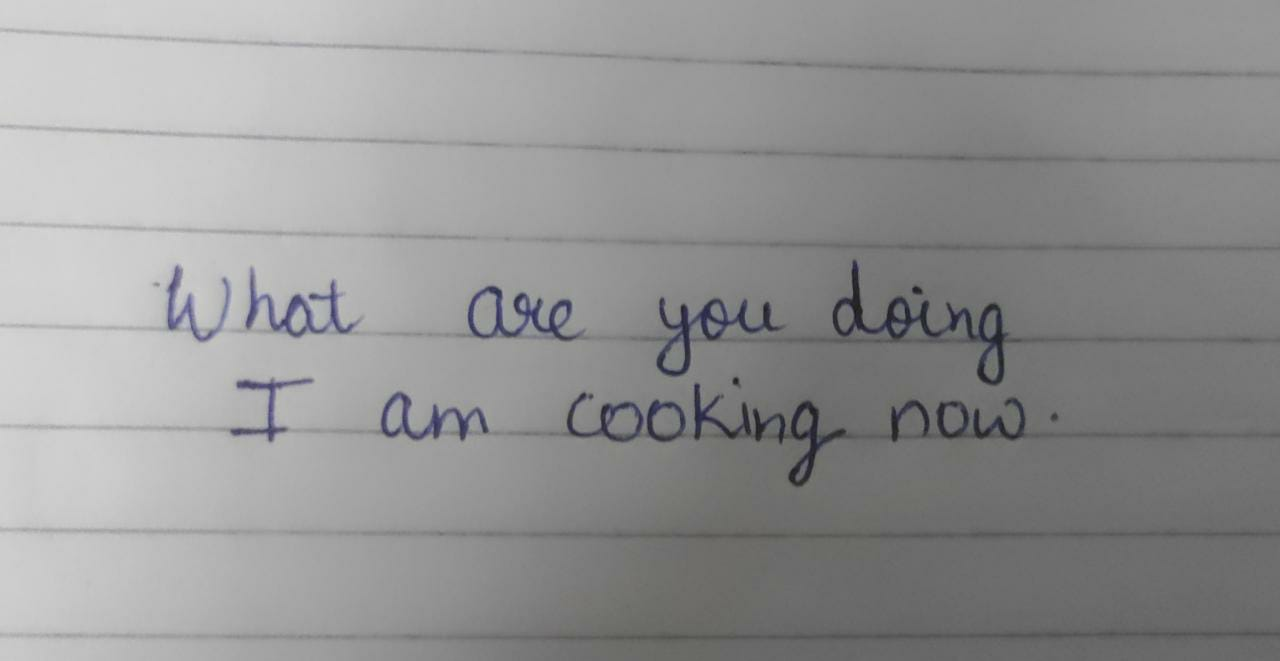

In [8]:
hw_image = show_image('f.jpeg')

In [9]:
ocr_image(hw_image)

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'William Coughton.'

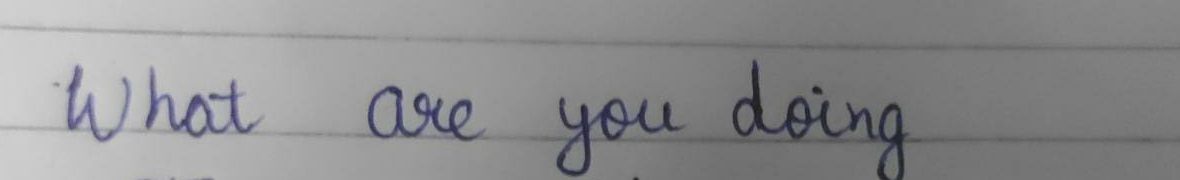

In [10]:
hw_image2 = hw_image.crop((100, 200, hw_image.size[0], 380))
display(hw_image2)

In [11]:
x=ocr_image(hw_image2)

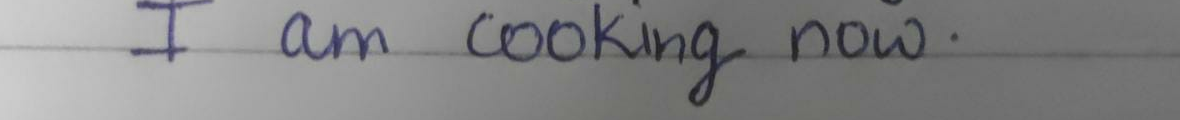

In [12]:
hw_image3 = hw_image.crop((100, 380, hw_image.size[0], 500))
display(hw_image3)

In [13]:
y=ocr_image(hw_image3)

In [14]:
x

'What are you doing'

In [15]:
y

'I am cooking now.'

In [16]:
import cv2

In [17]:
image_file="f.jpeg"

In [18]:
!pip install scikit-image


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


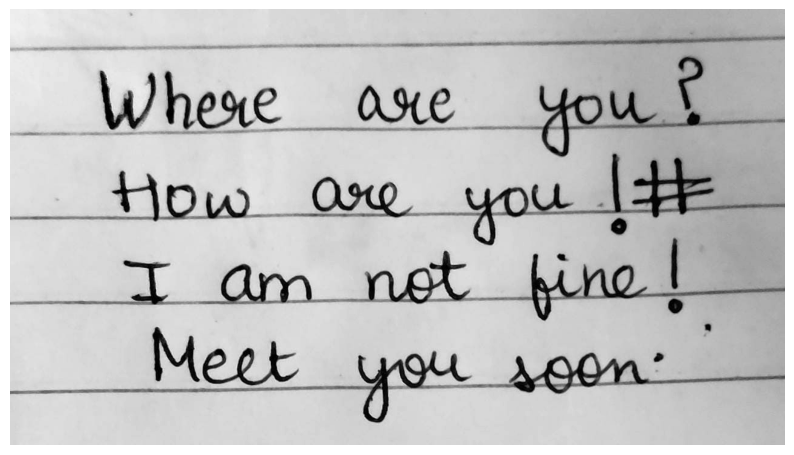

In [19]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

# read the image, check if its 3 channel or grayscale, based on 
# that convert to grayscale
img = imread("x.jpeg")
if img.ndim > 2: # is this is a rgb/rgba image
    img = rgb2gray(img)

plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.show() # preview


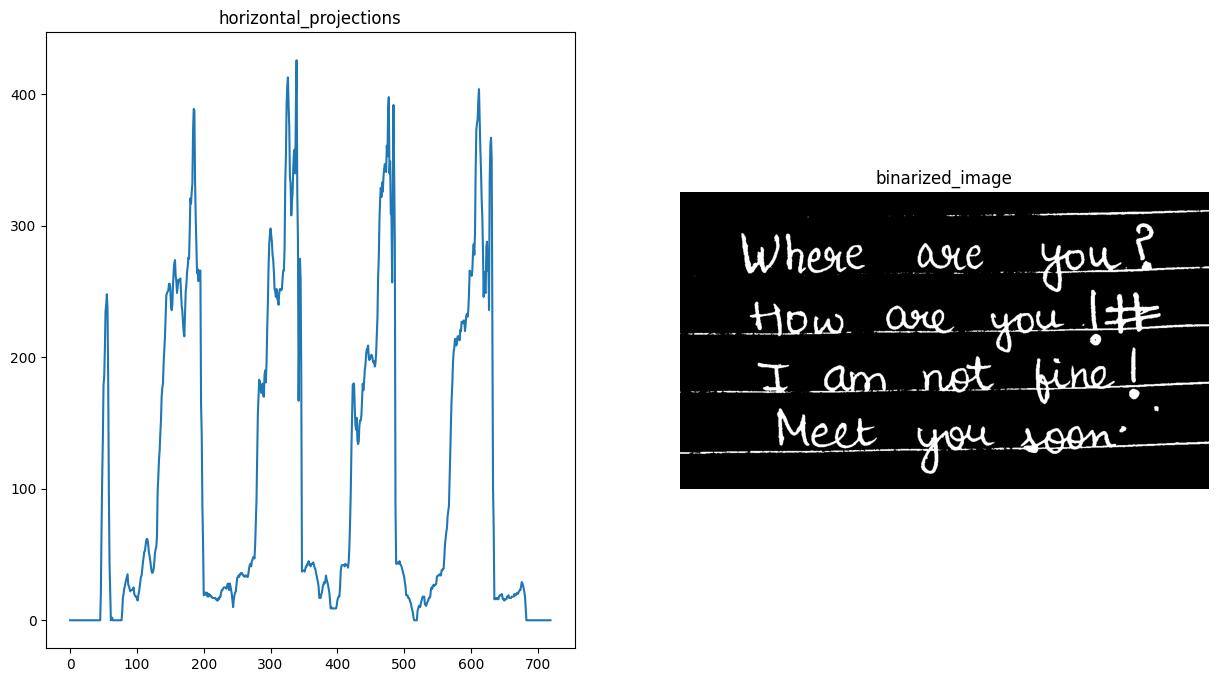

In [20]:
from skimage.filters import threshold_otsu
import numpy as np

def horizontal_projections(sobel_image):
    return np.sum(sobel_image, axis=1)  

def binarize_image(image):
    threshold = threshold_otsu(img)
    return image < threshold
    
binarized_image = binarize_image(img)
hpp = horizontal_projections(binarized_image)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.set_title("horizontal_projections")
ax1.plot(hpp)

ax2.axis("off")
ax2.set_title("binarized_image")
ax2.imshow(binarized_image, cmap="gray")

plt.show()


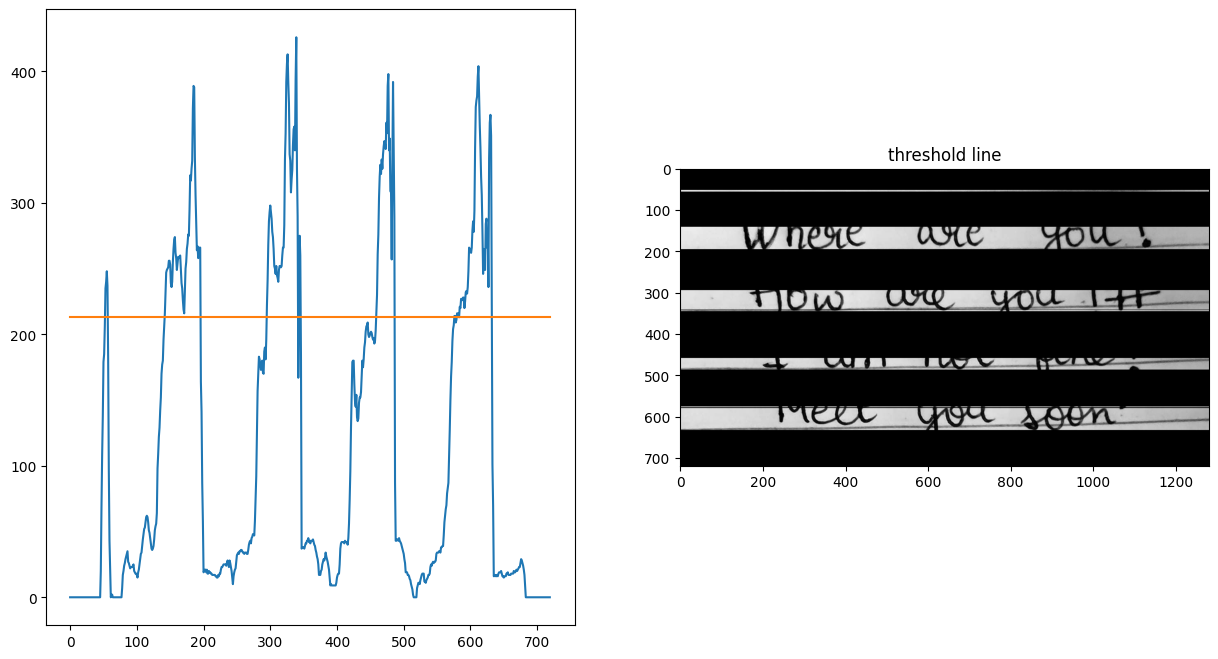

In [21]:
# find the midway where we can make a threshold and extract the peaks regions
def find_peak_regions(hpp, threshold):
    
    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

# find the threshold from where anything above is considered a peak region
# using the average for now but this needs further research. This may or may not work on all images.
threshold = (np.max(hpp)-np.min(hpp))/2
peaks = find_peak_regions(hpp, threshold)

peaks_indexes = np.array(peaks)[:, 0].astype(int)

segmented_img = np.copy(img)
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes:
        segmented_img[ri, :] = 0

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.plot(hpp)
ax2.set_title("threshold line")
ax1.plot([0, img.shape[0]], [threshold, threshold,])
ax2.imshow(segmented_img, cmap="gray")
plt.show()

In [22]:
# group the peaks through which we will be doing path planning.
diff_between_consec_numbers = np.diff(peaks_indexes) # difference between consecutive numbers
indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
# remove very small regions, these are basically errors in algorithm because of our threshold value
peak_groups = [item for item in peak_groups if len(item) > 10]
print("peak groups found", len(peak_groups))

peak groups found 6


In [23]:
#a star path planning algorithm 
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):

    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))
    
    while oheap:

        current = heappop(oheap)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))
                
    return []

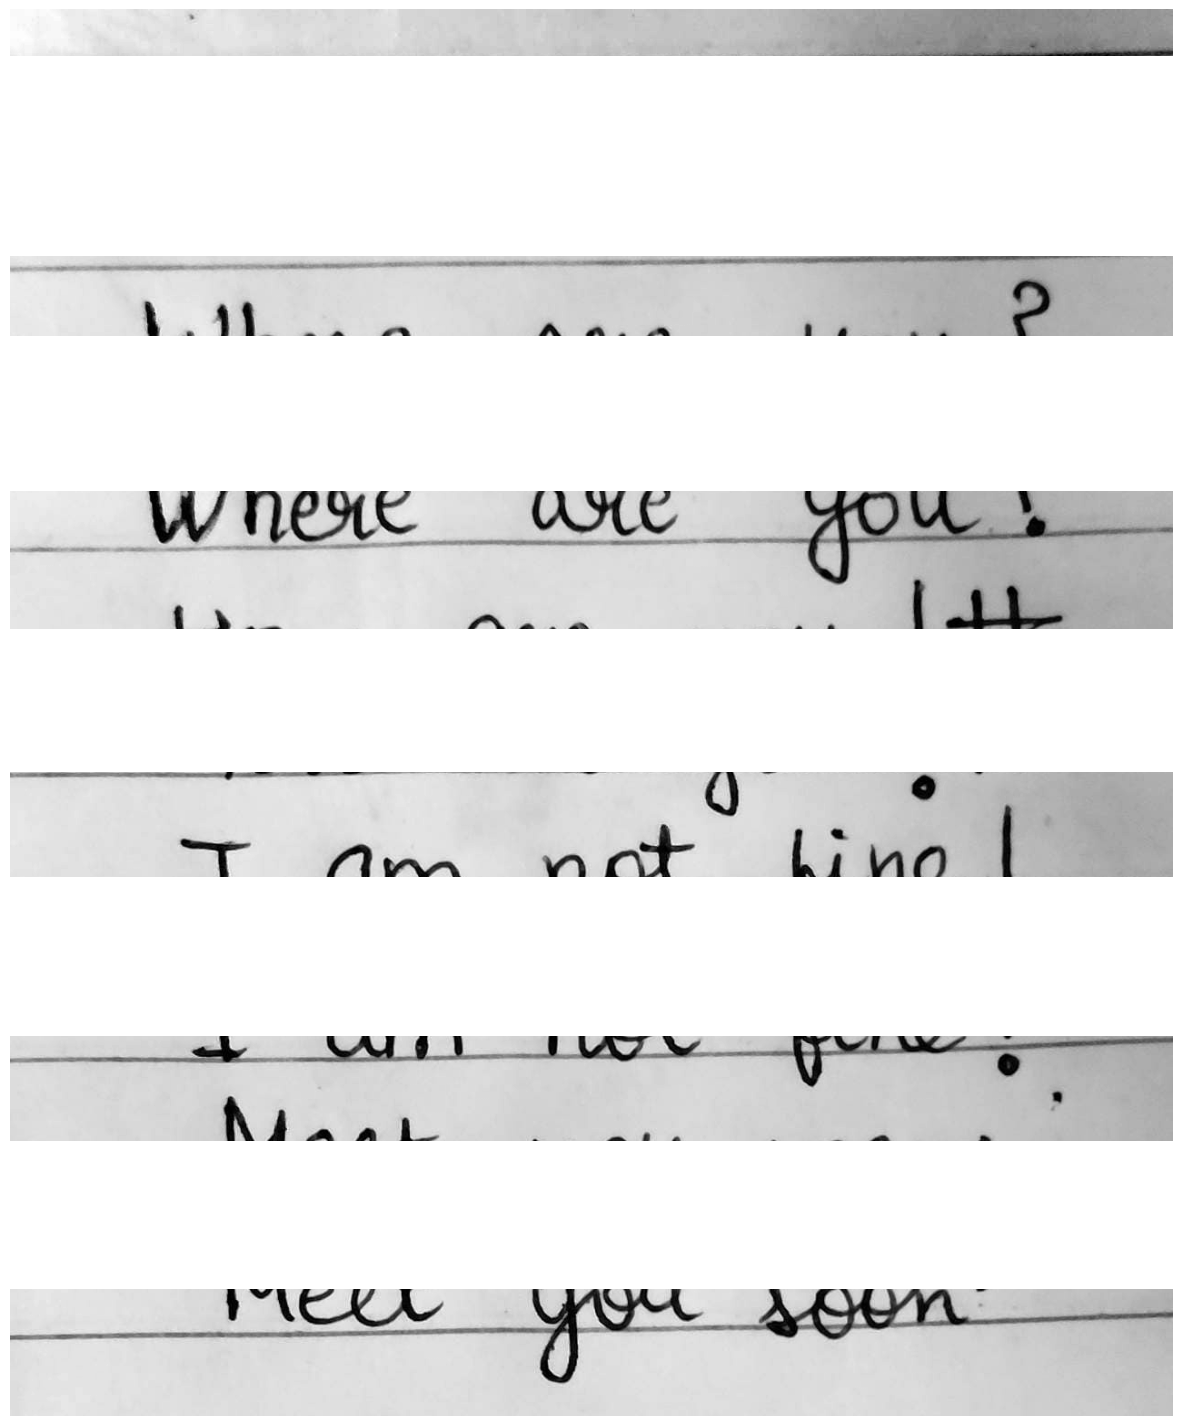

In [24]:
# Visualize the peak images
fig, ax = plt.subplots(nrows=len(peak_groups), ncols=1, figsize=(15,20))
for index, sub_image_index in enumerate(peak_groups):
    sub_image = img[sub_image_index[0]:sub_image_index[-1]]
    ax[index].axis("off")
    ax[index].imshow(sub_image, cmap="gray")
plt.show()

In [25]:
# now that everything is cleaner, its time to segment all the lines using the A* algorithm
def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary * 1
    return binary

binary_image = get_binary(img)
segment_separating_lines = []
for i, sub_image_index in enumerate(peak_groups):
    nmap = binary_image[sub_image_index[0]:sub_image_index[-1]]
    path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
    offset_from_top = sub_image_index[0]
    path[:,0] += offset_from_top
    segment_separating_lines.append(path)


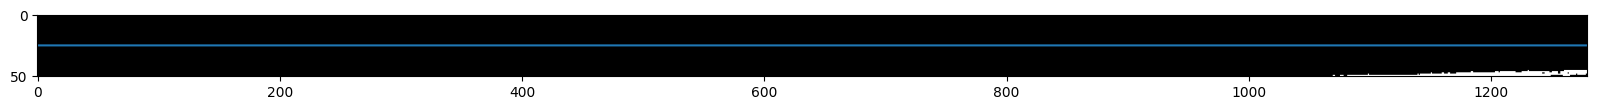

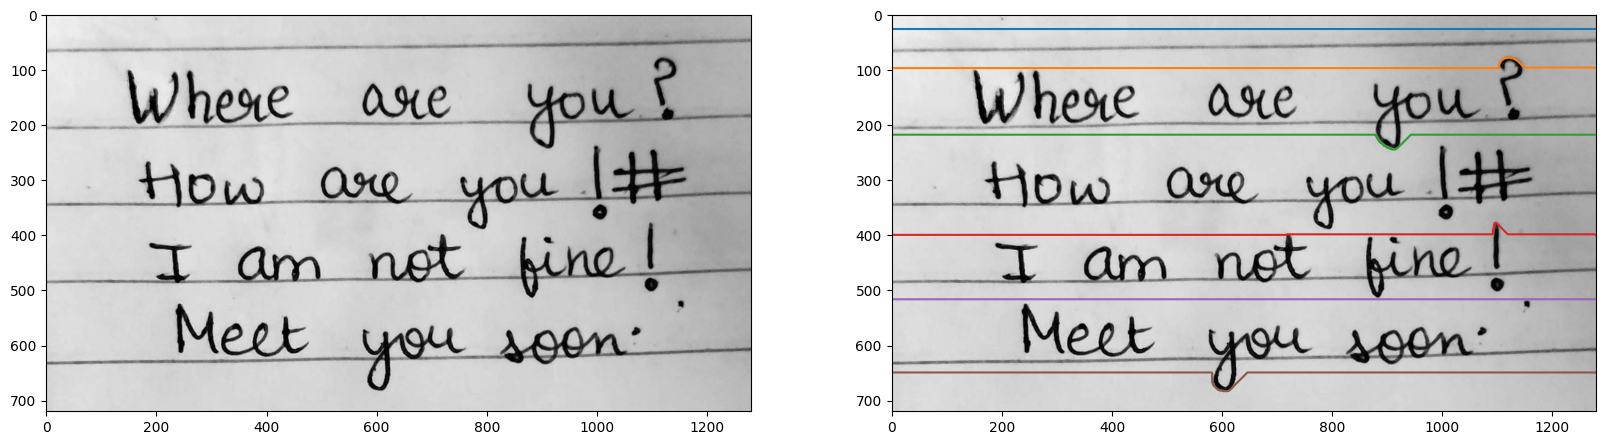

In [26]:
# visualize a sample
cluster_of_interest = peak_groups[0]
offset_from_top = cluster_of_interest[0]
nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[-1],:]
plt.figure(figsize=(20,20))
plt.imshow(nmap, cmap="gray")

path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
plt.plot(path[:,1], path[:,0])

offset_from_top = cluster_of_interest[0]
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
for path in segment_separating_lines:
    ax[1].plot((path[:,1]), path[:,0])
ax[1].imshow(img, cmap="gray")
ax[0].imshow(img, cmap="gray")

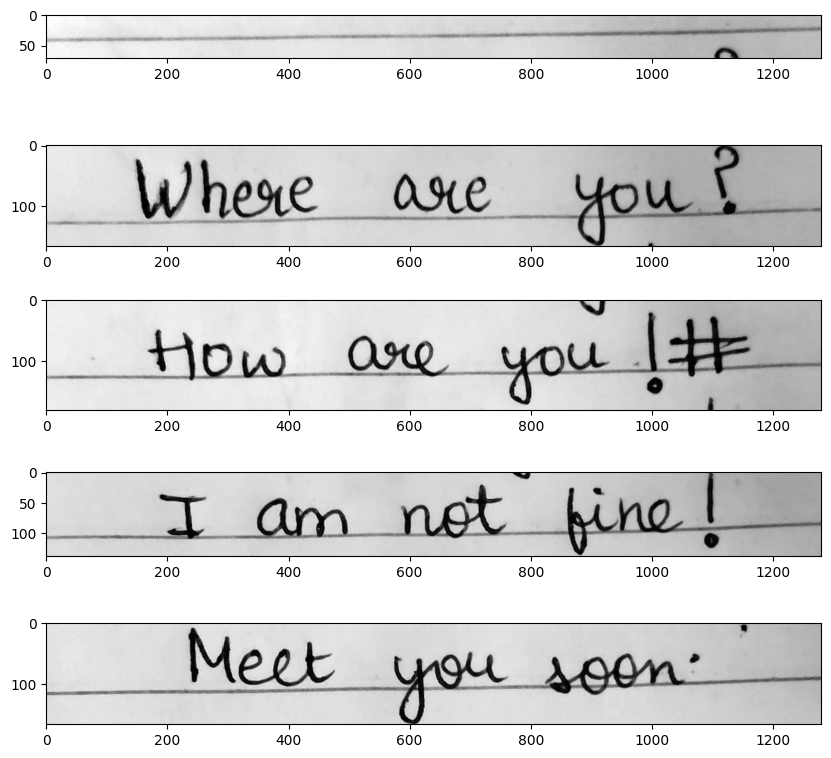

In [27]:

seperated_images = []
for index, line_segments in enumerate(segment_separating_lines):
    if index < len(segment_separating_lines)-1:
        lower_line = np.min(segment_separating_lines[index][:,0])
        upper_line = np.max(segment_separating_lines[index+1][:,0])
        seperated_images.append(img[lower_line:upper_line])

# visualize it
j=0;
fig, ax = plt.subplots(figsize=(10,10), nrows=len(seperated_images))
for index, line_image in enumerate(seperated_images):
    hw_imag=ax[index].imshow(line_image, cmap="gray")


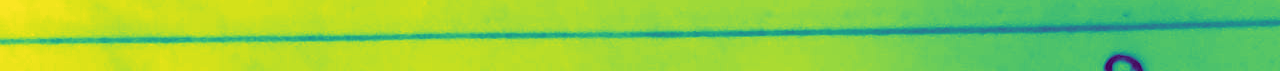

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


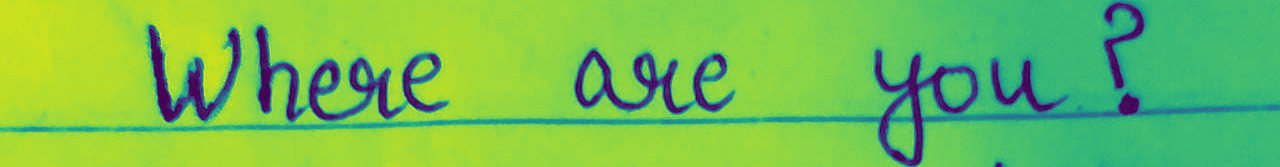

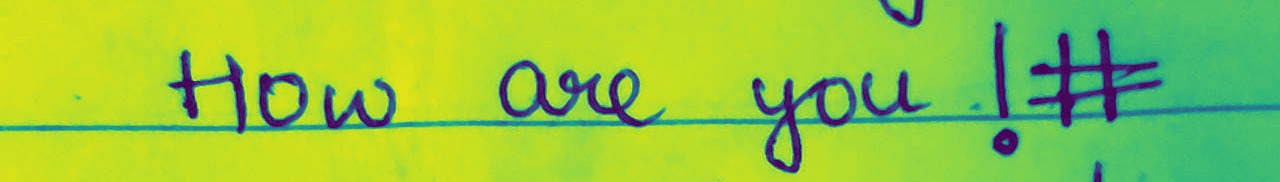

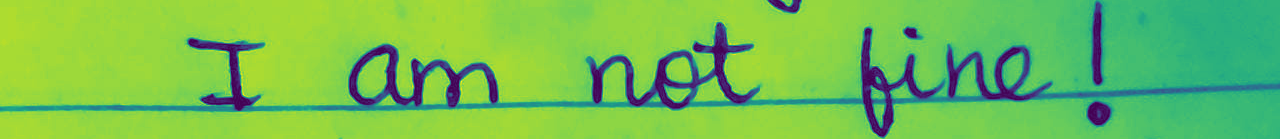

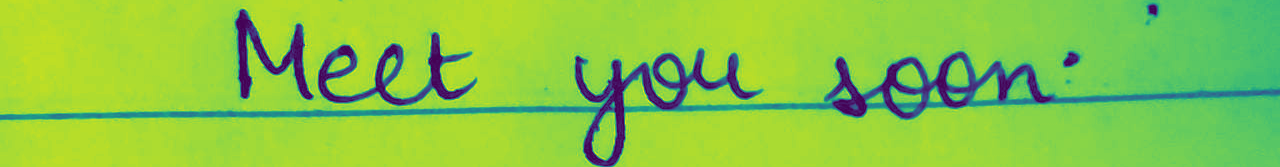

In [28]:
a=len(seperated_images)
names=[]
for i in seperated_images:
    plt.imsave('abc.png',i)
    hw_u=show_image('abc.png')
    names.append(ocr_image(hw_u))

In [29]:
names[0]

'0 0'

In [30]:
names[1]

'Where are you!'

In [31]:
names[2]

'How are you #'

In [32]:
names[3]

"I am not fine! '"

In [33]:
names[4]

"Meet you soon : '"

In [80]:
from docx import Document
from docx.shared import Cm

In [81]:
name=input('What is the heading of the document you want to give?\n')


What is the heading of the document you want to give?
my first task


In [82]:
fo=input('Please specify the font size as well\n')

Please specify the font size as well
40


In [83]:
fo=float(fo)

In [84]:
fo

40.0

In [85]:
document = Document()
style = document.styles['Normal']
style.font.name = 'Calibri'
header_section = document.sections[0]
header = header_section.header
header_text = header.paragraphs[0]
header_text.text = name
from docx.shared import Pt
font = style.font
font.size = Pt(fo)

In [86]:
for b in names:
    p = document.add_paragraph(b)

In [87]:
document.save('efg.docx')

In [88]:
from docx2pdf import convert
docx_file = 'efg.docx'
pdf_file = 'efg.pdf'
convert(docx_file, pdf_file)

  0%|          | 0/1 [00:00<?, ?it/s]

In [89]:
import matplotlib.pyplot as plt
import cv2
import easyocr
from pylab import rcParams
from IPython.display import Image

In [40]:
rcParams['figure.figsize'] = 8, 16


In [41]:
reader = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


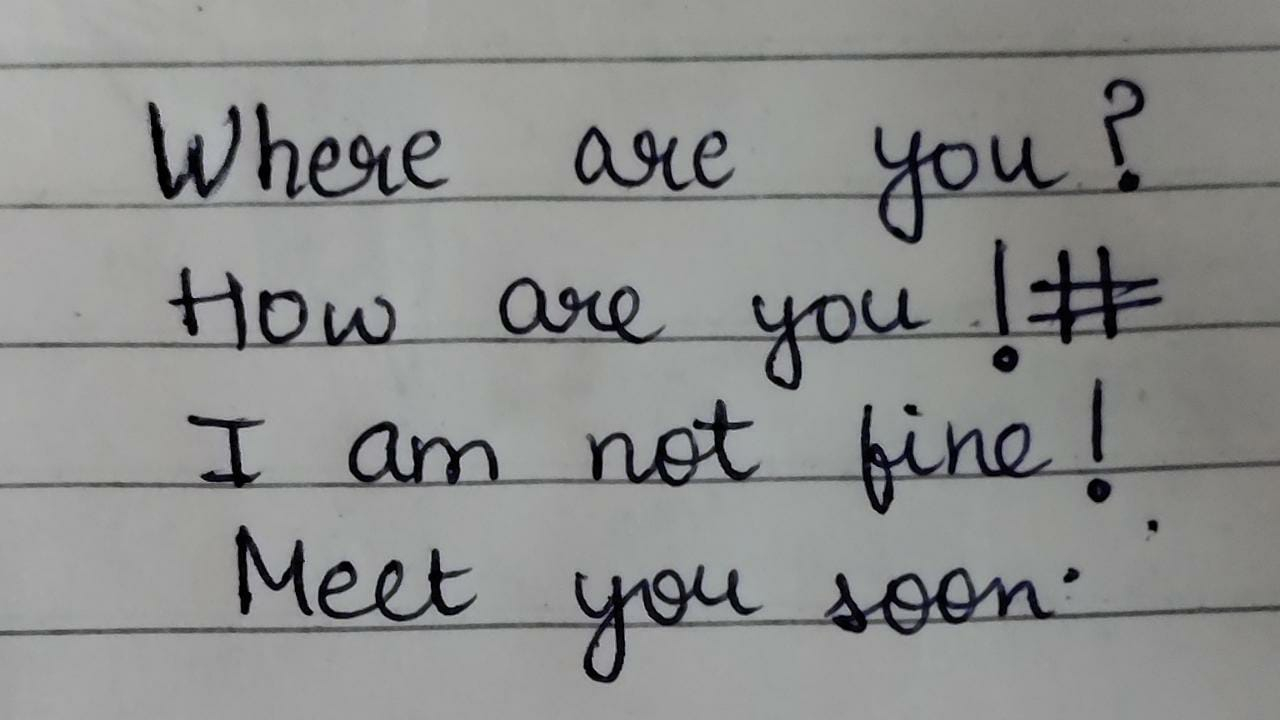

In [42]:
file_name = "x.jpeg"
Image(file_name)

In [43]:
output = reader.readtext(file_name)

In [44]:
output

[([[136, 90], [464, 90], [464, 210], [136, 210]],
  'Wheste',
  0.4969014433682393),
 ([[567, 111], [749, 111], [749, 201], [567, 201]], 'Qse', 0.3922208108038467),
 ([[849, 66], [1166, 66], [1166, 261], [849, 261]],
  'You ?',
  0.47731901700037555),
 ([[164, 260], [410, 260], [410, 356], [164, 356]],
  'How_',
  0.7966915369033813),
 ([[489, 259], [681, 259], [681, 356], [489, 356]], 'QsQ', 0.6523895244219593),
 ([[964, 234], [1170, 234], [1170, 362], [964, 362]],
  'Ji+',
  0.049126814699179636),
 ([[187, 407], [285, 407], [285, 495], [187, 495]], 'I', 0.9047286161222843),
 ([[341, 409], [506, 409], [506, 498], [341, 498]], 'Om', 0.20548582347675923),
 ([[571, 387], [774, 387], [774, 498], [571, 498]], 'net', 0.9676815492581872),
 ([[838, 382], [1123, 382], [1123, 522], [838, 522]],
  'fine !',
  0.2805674420590155),
 ([[216, 512], [498, 512], [498, 645], [216, 645]],
  'Meee',
  0.5038331747055054),
 ([[550, 537], [1104, 537], [1104, 690], [550, 690]],
  "You_Agan '",
  0.126711014

In [45]:
for x in output:
    print(x[1])

Wheste
Qse
You ?
How_
QsQ
Ji+
I
Om
net
fine !
Meee
You_Agan '
You


In [46]:
cord = output[5][0]

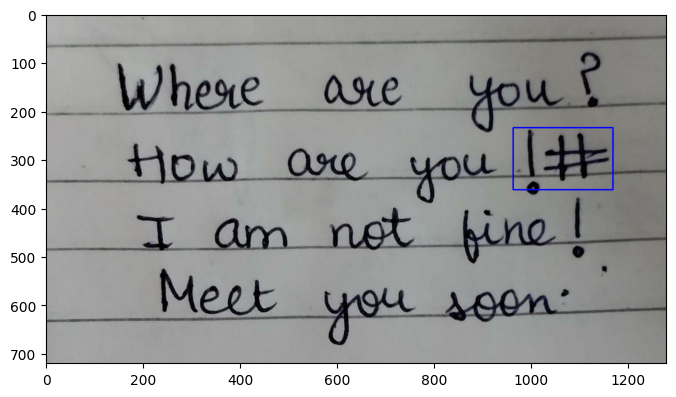

In [47]:
x_min, y_min = [int(min(idx)) for idx in zip(*cord)]
x_max, y_max = [int(max(idx)) for idx in zip(*cord)]
image = cv2.imread(file_name)
cv2.rectangle(image,(x_min,y_min),(x_max,y_max),(255,0,0),2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [48]:
!sudo apt install tesseract-ocr

'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [49]:
!pip install pytesseract


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
try:
    from PIL import Image
except ImportError:
    import Image

In [51]:
import pytesseract

In [60]:
print(pytesseract.image_to_string(Image.open("a.jpeg")))

TAM PLAYING —
WHAT ARE YOU —____—
coo KIN @— | :


